In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import math
import sys
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import matplotlib.pyplot as plt
from torch.utils.tensorboard import writer, SummaryWriter
from torch.utils.data import DataLoader
from math import pi

from torch import nn
from torch.nn.utils import spectral_norm

## Data

The historical data has been downloaded from https://finance.yahoo.com/ 

In [2]:
data = pd.read_csv('./data/SPY.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.370279,480500
1,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.426161,201300
2,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.705482,529400
3,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.817228,531500
4,1993-02-05,44.96875,45.06250,44.71875,44.96875,26.798601,492100


Text(0.5, 0, 'Date')

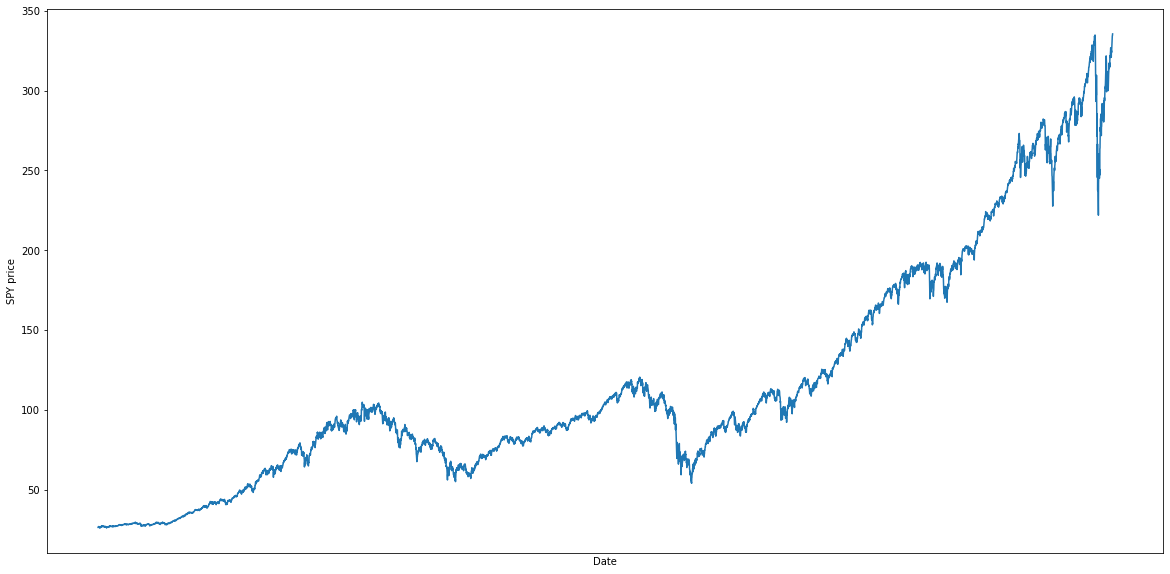

In [3]:
plt.figure(figsize=(20,10))
plt.plot(data['Date'],data['Adj Close'])
# plt.xticks(data['Adj Close'][::50])
plt.xticks([])  # Disable xticks.
plt.ylabel('SPY price')
plt.xlabel('Date')

In [4]:
data.shift(periods=1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,26.370279,480500.0
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,26.426161,201300.0
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.705482,529400.0
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.817228,531500.0
...,...,...,...,...,...,...,...
6927,2020-08-03,328.320007,329.619995,327.730011,328.790009,328.790009,53077900.0
6928,2020-08-04,327.859985,330.059998,327.859985,330.059998,330.059998,41917900.0
6929,2020-08-05,331.470001,332.390015,331.179993,332.109985,332.109985,42866400.0
6930,2020-08-06,331.480011,334.459991,331.130005,334.329987,334.329987,43679400.0


In [5]:
data['returns'] = (data['Adj Close'] - data.shift(periods=1)['Adj Close']) / data['Adj Close']

In [6]:
data = data.iloc[1:]
data['returns'][:5]

1    0.002115
2    0.010459
3    0.004167
4   -0.000695
5    0.000000
Name: returns, dtype: float64

Text(0.5, 0, 'Date')

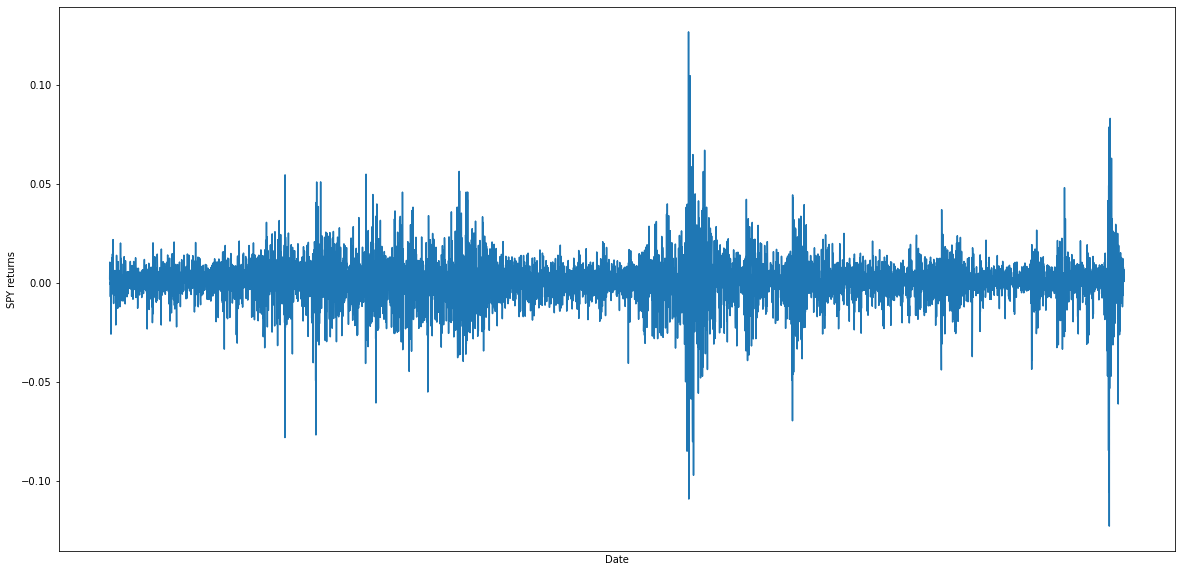

In [7]:
plt.figure(figsize=(20,10))
plt.plot(data['Date'], data['returns'])
# plt.xticks(data['Adj Close'][::50])
plt.xticks([])  # Disable xticks.
plt.ylabel('SPY returns')
plt.xlabel('Date')

In [8]:
from torch.utils.data import Dataset, DataLoader

class Returns(Dataset):
    def __init__(self, data_frame, window_size):
        self.data = data_frame.values
        self.window_size = window_size
        self.dataset = self._generate_dataset()

    def __len__(self):
        return self.data.shape[0] // self.window_size

    def __getitem__(self, index):
        return self.dataset[index]

    def _generate_dataset(self):
        dataset = []
        for i in range(2 * self.__len__() - 1):
            sample = self.data[int(i * self.window_size / 2): int(i * self.window_size / 2) + self.window_size]
            sample = np.squeeze(sample)
            dataset.append(sample)

        return np.array(dataset)

In [9]:
dataset = Returns(data[['returns']], 200)

In [10]:
dataset.__getitem__(1).shape

(200,)

In [11]:
from typing import Sequence

from torch.utils.data import Dataset
import numpy as np


class Sines(Dataset):

    def __init__(self, frequency_range: Sequence[float], amplitude_range: Sequence[float],
                 n_series: int = 200, datapoints: int = 100, seed: int = None):
        """
        Pytorch Dataset to produce sines.
        y = A * sin(B * x)
        :param frequency_range: range of A
        :param amplitude_range: range of B
        :param n_series: number of sines in your dataset
        :param datapoints: length of each sample
        :param seed: random seed
        """
        self.n_series = n_series
        self.datapoints = datapoints
        self.seed = seed
        self.frequency_range = frequency_range
        self.amplitude_range = amplitude_range
        self.dataset = self._generate_sines()

    def __len__(self):
        return self.n_series

    def __getitem__(self, idx):
        return self.dataset[idx]

    def _generate_sines(self):
        if self.seed is not None:
            np.random.seed(self.seed)

        x = np.linspace(start=0, stop=2 * np.pi, num=self.datapoints)
        low_freq, up_freq = self.frequency_range[0], self.frequency_range[1]
        low_amp, up_amp = self.amplitude_range[0], self.amplitude_range[1]

        freq_vector = (up_freq - low_freq) * np.random.rand(self.n_series, 1) + low_freq
        ampl_vector = (up_amp - low_amp) * np.random.rand(self.n_series, 1) + low_amp

        return ampl_vector * np.sin(freq_vector * x)

In [12]:
dataset = Sines(frequency_range=[0, 2 * pi], amplitude_range=[0, 2 * pi], seed=42, n_series=200)
# dataloader = DataLoader(dataset, batch_size=args.batches)

In [13]:
dataset.__getitem__(3).shape

(100,)

## GAN

In [14]:
class ExpandDimension(nn.Module):
    def forward(self, x):
        return x.unsqueeze(1)

In [15]:
class SqueezeDimension(nn.Module):
    def forward(self, x):
        return x.squeeze(1)

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = self.create_architecture()

    def forward(self, input):
        return self.main(input)
    
    def create_architecture(self):
        return nn.Sequential(nn.Linear(50, 100),
                     nn.LeakyReLU(0.2, inplace=True),
                     ExpandDimension(),
                     spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                     nn.Upsample(200),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Upsample(400),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Upsample(800),

                     spectral_norm(nn.Conv1d(32, 1, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),

                     SqueezeDimension(),
                     nn.Linear(800, 100)
                     )

In [17]:
g = Generator()
print(g)

Generator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ExpandDimension()
    (3): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): Upsample(size=200, mode=nearest)
    (5): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Upsample(size=400, mode=nearest)
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Upsample(size=800, mode=nearest)
    (11): Conv1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): SqueezeDimension()
    (14): Linear(in_features=800, out_features=100, bias=True)
  )
)


In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_feat, n_filters, kernel_size, padding, upsample_size):
            layers = []
            layers.append(nn.Conv1d(in_feat, n_filters, kernel_size, padding=padding))
            layers.append(nn.BatchNorm1d(n_filters, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Upsample(upsample_size))
            return layers
        
        self.model = nn.Sequential(
            nn.Linear(50, 100),
            nn.BatchNorm1d(100, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            ExpandDimension(),
            *block(1, n_filters=32, kernel_size=3, padding=1, upsample_size=200),
            *block(32, n_filters=32, kernel_size=3, padding=1, upsample_size=400),
            *block(32, n_filters=32, kernel_size=3, padding=1, upsample_size=800),
            nn.Conv1d(32, 1, 3, padding=1),
            nn.BatchNorm1d(1, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            SqueezeDimension(),
            nn.Linear(800, 100),
            nn.BatchNorm1d(100, 0.8),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.model(x)

In [19]:
g = Generator()
print(g)

Generator(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ExpandDimension()
    (4): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Upsample(size=200, mode=nearest)
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Upsample(size=400, mode=nearest)
    (12): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): Upsample(siz

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = self.create_architecture()

    def forward(self, input):
        return self.main(input)
    
    def create_architecture(self):
        return nn.Sequential(ExpandDimension(),
                     spectral_norm(nn.Conv1d(1, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.MaxPool1d(2),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.MaxPool1d(2),

                     spectral_norm(nn.Conv1d(32, 32, 3, padding=1), n_power_iterations=10),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Flatten(),

                     nn.Linear(800, 50),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Linear(50, 15),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Linear(15, 1)
                     )

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def block(in_feat, n_filters, kernel_size, padding):
            layers = []
            layers.append(nn.Conv1d(in_feat, n_filters, kernel_size, padding=padding))
            layers.append(nn.BatchNorm1d(n_filters, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.MaxPool1d(2))
            return layers
    
        self.model = nn.Sequential(
            ExpandDimension(),
            *block(1, n_filters=32, kernel_size=3, padding=1),
            *block(32, n_filters=32, kernel_size=3, padding=1),
            nn.Conv1d(32, 32, 3, padding=1),
            nn.BatchNorm1d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(800, 50),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(50, 15),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(15, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [22]:
class Trainer:
    NOISE_LENGTH = 50

    def __init__(self, generator, critic, gen_optimizer, critic_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=200, use_cuda=False, checkpoint_frequency=200):
        self.g = generator
        self.g_opt = gen_optimizer
        self.c = critic
        self.c_opt = critic_optimizer
        self.losses = {'g': [], 'c': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.checkpoint_frequency = checkpoint_frequency

        if self.use_cuda:
            self.g.cuda()
            self.c.cuda()

    def _critic_train_iteration(self, real_data):
        batch_size = real_data.size()[0]
        noise_shape = (batch_size, self.NOISE_LENGTH)
        generated_data = self.sample_generator(noise_shape)

        real_data = Variable(real_data)

        if self.use_cuda:
            real_data = real_data.cuda()

        # Pass data through the Critic
        c_real = self.c(real_data)
        c_generated = self.c(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(real_data, generated_data)
        self.losses['GP'].append(gradient_penalty.data.item())

        # Create total loss and optimize
        self.c_opt.zero_grad()
        d_loss = c_generated.mean() - c_real.mean() + gradient_penalty
        d_loss.backward()
        self.c_opt.step()

        self.losses['c'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        self.g_opt.zero_grad()
        batch_size = data.size()[0]
        latent_shape = (batch_size, self.NOISE_LENGTH)

        generated_data = self.sample_generator(latent_shape)

        # Calculate loss and optimize
        d_generated = self.c(generated_data)
        g_loss = - d_generated.mean()
        print(g_loss)
        g_loss.backward()
        self.g_opt.step()
        self.losses['g'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):

        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Pass interpolated data through Critic
        prob_interpolated = self.c(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda
                               else torch.ones(prob_interpolated.size()), create_graph=True,
                               retain_graph=True)[0]
        # Gradients have shape (batch_size, num_channels, series length),
        # here we flatten to take the norm per example for every batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of the
        # square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader, epoch):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data.float())
            # Only update generator every critic_iterations iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data)

#             if i % self.print_every == 0:
#                 global_step = i + epoch * len(data_loader.dataset)
#                 writer.add_scalar('Losses/Critic', self.losses['c'][-1], global_step)
#                 writer.add_scalar('Losses/Gradient Penalty', self.losses['GP'][-1], global_step)
#                 writer.add_scalar('Gradient Norm', self.losses['gradient_norm'][-1], global_step)

#                 if self.num_steps > self.critic_iterations:
#                     writer.add_scalar('Losses/Generator', self.losses['g'][-1], global_step)

    def train(self, data_loader, epochs, plot_training_samples=True, checkpoint=None):

        if checkpoint:
            path = os.path.join('checkpoints', checkpoint)
            state_dicts = torch.load(path, map_location=torch.device('cpu'))
            self.g.load_state_dict(state_dicts['g_state_dict'])
            self.c.load_state_dict(state_dicts['d_state_dict'])
            self.g_opt.load_state_dict(state_dicts['g_opt_state_dict'])
            self.c_opt.load_state_dict(state_dicts['d_opt_state_dict'])
       
        # Define noise_shape
        noise_shape = (1, self.NOISE_LENGTH)
        
        if plot_training_samples:
            # Fix latents to see how series generation improves during training
            fixed_latents = Variable(self.sample_latent(noise_shape))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()

        for epoch in tqdm(range(epochs)):

            # Sample a different region of the latent distribution to check for mode collapse
            dynamic_latents = Variable(self.sample_latent(noise_shape))
            if self.use_cuda:
                dynamic_latents = dynamic_latents.cuda()

            self._train_epoch(data_loader, epoch + 1)

            # Save checkpoint
            if epoch % self.checkpoint_frequency == 0:
                torch.save({
                    'epoch': epoch,
                    'd_state_dict': self.c.state_dict(),
                    'g_state_dict': self.g.state_dict(),
                    'd_opt_state_dict': self.c_opt.state_dict(),
                    'g_opt_state_dict': self.g_opt.state_dict(),
                }, 'checkpoints/epoch_{}.pkl'.format(epoch))

#             if plot_training_samples and (epoch % self.print_every == 0):
#                 self.g.eval()
#                 # Generate fake data using both fixed and dynamic latents
#                 fake_data_fixed_latents = self.g(fixed_latents).cpu().data
#                 fake_data_dynamic_latents = self.g(dynamic_latents).cpu().data

#                 plt.figure()
#                 plt.plot(fake_data_fixed_latents.numpy()[0].T)
# #                 plt.savefig('training_samples/fixed_latents/series_epoch_{}.png'.format(epoch))
#                 plt.close()

#                 plt.figure()
#                 plt.plot(fake_data_dynamic_latents.numpy()[0].T)
# #                 plt.savefig('training_samples/dynamic_latents/series_epoch_{}.png'.format(epoch))
#                 plt.close()
#                 self.g.train()

    def sample_generator(self, latent_shape):
        latent_samples = Variable(self.sample_latent(latent_shape))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()

        return self.g(latent_samples)

    @staticmethod
    def sample_latent(shape):
        return torch.randn(shape)

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        return generated_data.data.cpu().numpy()


if __name__ == '__main__':
#     parser = argparse.ArgumentParser(prog='GANetano', usage='%(prog)s [options]')
#     parser.add_argument('-ln', '--logname', type=str, dest='log_name', default=None, required=True,
#                         help='tensorboard filename')
#     parser.add_argument('-e', '--epochs', type=int, dest='epochs', default=15000, help='number of training epochs')
#     parser.add_argument('-bs', '--batches', type=int, dest='batches', default=16,
#                         help='number of batches per training iteration')
#     parser.add_argument('-cp', '--checkpoint', type=str, dest='checkpoint', default=None,
#                         help='checkpoint to use for a warm start')


#     args = parser.parse_args()
    n_epochs = 300
    batch_size = 200

    # Instantiate Generator and Critic + initialize weights
    g = Generator()

    g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
    d = Discriminator()

    d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)

    # Create Dataloader
#     dataset = Sines(frequency_range=[0, 2 * pi], amplitude_range=[0, 2 * pi], seed=42, n_series=200)
#     dataloader = DataLoader(dataset, batch_size=args.batches)
    dataset = Returns(data[['returns']], 100)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Instantiate Trainer
    trainer = Trainer(g, d, g_opt, d_opt, use_cuda=torch.cuda.is_available())
    # Train model
    print('Training is about to start...')
    # Instantiate Tensorboard writer
#     tb_logdir = os.path.join('..', 'tensorboard', args.log_name)
    tb_logdir = os.path.join('..', 'tensorboard', 'Log')
    writer = SummaryWriter(log_dir=tb_logdir)

#     trainer.train(dataloader, epochs=n_epochs, plot_training_samples=True, checkpoint=args.checkpoint)
    trainer.train(dataloader, epochs=n_epochs, plot_training_samples=True, checkpoint='')

  0%|          | 0/300 [00:00<?, ?it/s]

Training is about to start...


  2%|▏         | 5/300 [00:00<00:59,  4.93it/s]

tensor(-0.2310, grad_fn=<NegBackward>)


  3%|▎         | 10/300 [00:01<00:55,  5.20it/s]

tensor(-0.2312, grad_fn=<NegBackward>)


KeyboardInterrupt: 

In [23]:
sample_size = 200
sample = trainer.sample_latent(sample_size)
sample

tensor([-0.8746,  0.6028, -0.6427,  0.7671,  0.2659,  1.7834, -2.1422,  0.5420,
        -0.3899, -0.1607, -1.4857,  1.3590, -0.0998,  2.0364,  1.2660,  0.7036,
        -0.5442,  1.1582, -1.6997,  0.1335,  1.9393, -0.4088,  0.3932,  0.5296,
         2.1327,  2.0403,  0.0536, -0.6671,  0.9588,  0.3250, -0.8679, -1.0230,
         0.2510,  0.0074, -1.1849, -0.9799,  0.0061, -1.8903, -0.1618,  0.6636,
        -1.4325, -2.4334, -0.7442, -2.2926,  0.0177, -1.6817, -0.1027,  0.1475,
        -0.2411, -0.6001, -1.7301,  0.2576, -1.8665,  0.2779, -1.0596,  1.4788,
        -0.8092,  0.4951,  0.8029,  0.3088,  1.3127,  0.8258,  0.1217, -0.1753,
        -0.7110,  0.3198,  0.5056,  0.3606, -1.0526,  0.7972,  0.8773, -1.0321,
         1.5935, -1.2378,  0.9572,  0.9707,  0.1388, -0.0786,  0.1431,  1.0549,
         1.4756, -0.0133, -1.2283,  0.6559,  2.1969, -0.2838, -0.1291, -0.4754,
        -0.4311,  0.6323,  0.3410, -0.6169,  1.5380,  0.3606, -0.7354, -0.9871,
        -0.1404, -1.2742, -0.9120,  0.65

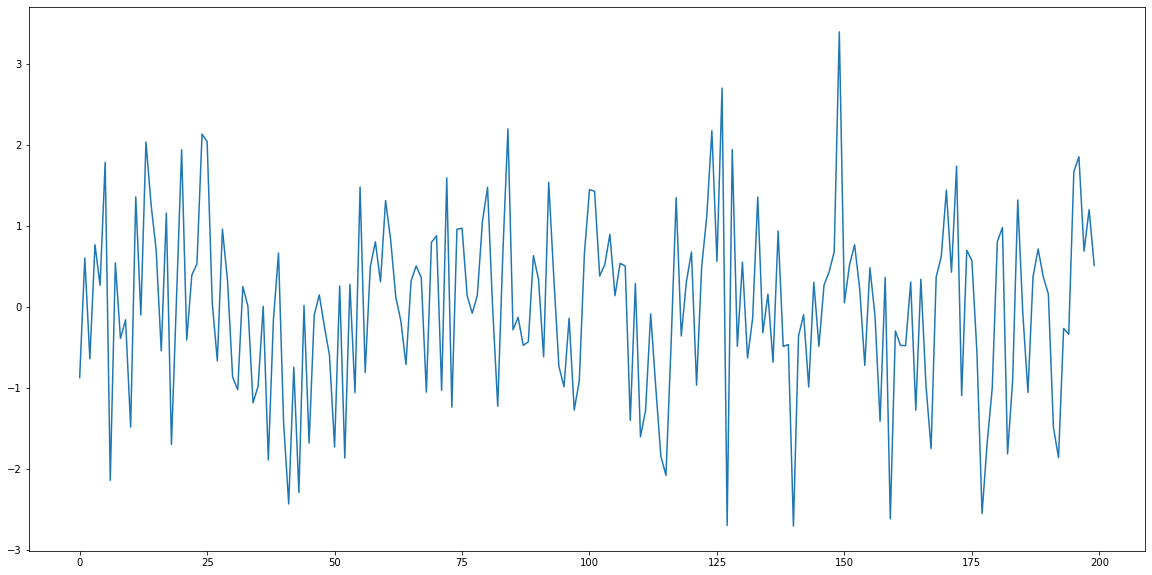

In [24]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,sample_size), sample)
# plt.xticks(data['Adj Close'][::50])
# plt.xticks([])  # Disable xticks.
# plt.ylabel('SPY returns')
# plt.xlabel('Date')

## Statistical Analysis of Synthetic Series

In [25]:
from scipy.stats import kurtosis

In [26]:
ordered_returns = data[['returns']].sort_values(by=['returns'])
ordered_returns['cdf'] = np.arange(1,len(ordered_returns)+1) / (len(ordered_returns)+1)
ordered_returns

,returns,cdf
6829,-0.122868,0.000144
3957,-0.109198,0.000289
6827,-0.105800,0.000433
3989,-0.097187,0.000577
3945,-0.085025,0.000721
...,...,...
4065,0.067015,0.999279
6828,0.078754,0.999423
6835,0.083076,0.999567
3966,0.104629,0.999711


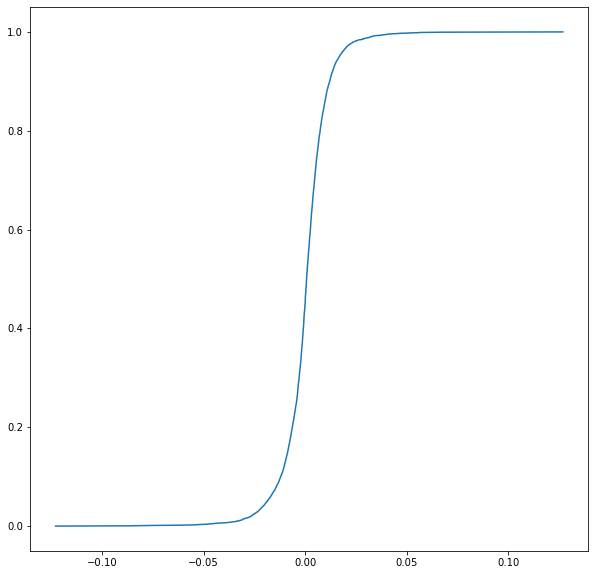

In [27]:
plt.figure (figsize=(10,10))
plt.plot(ordered_returns['returns'], ordered_returns['cdf'])

In [32]:
import seaborn as sns
import scipy.stats as stats

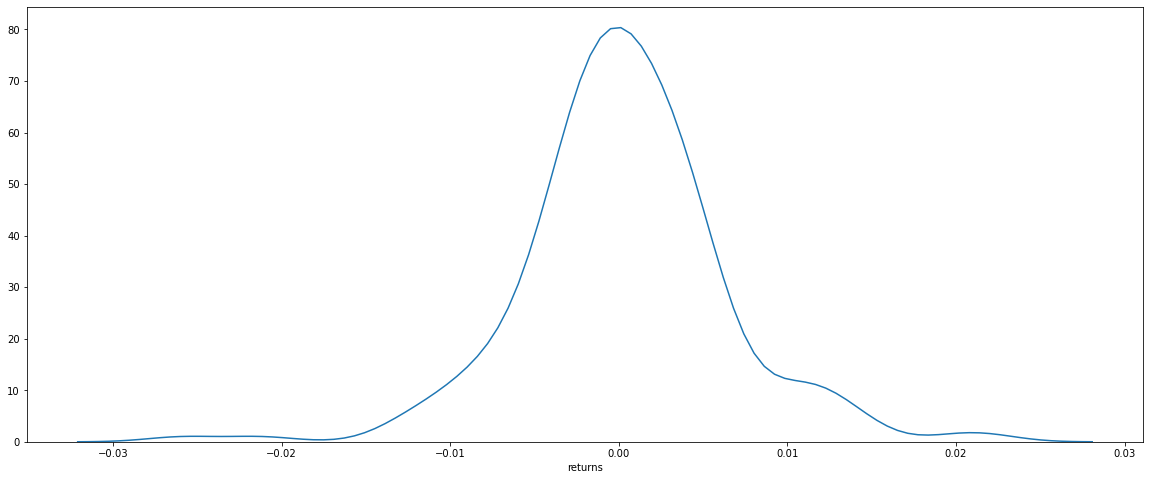

In [63]:
plt.figure (figsize=(20,8))
sns.distplot(data['returns'][:200], hist=False);
# mu = np.mean(data['returns'])
# sigma = np.std(data['returns'])
# x = np.linspace(mu - 10*sigma, mu + 10*sigma, 100)
# plt.plot(x, stats.norm.pdf(x, mu, sigma))
# plt.show()

In [67]:
data['returns'].shape

(6931,)

In [68]:
kurtosis(data['returns'][:6000])

9.717366229410148

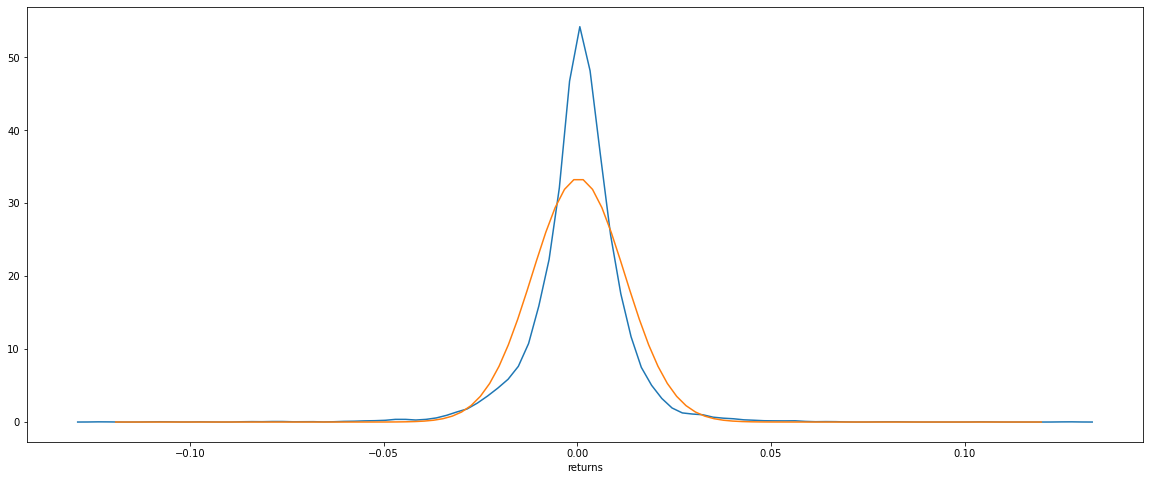

In [35]:
plt.figure (figsize=(20,8))
sns.distplot(data['returns'], hist=False);
mu = np.mean(data['returns'])
sigma = np.std(data['returns'])
x = np.linspace(mu - 10*sigma, mu + 10*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

In [36]:
kurtosis(data['returns'])

11.904033322869816

/Users/nabeel/anaconda3/envs/gan_returns/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nabeel/anaconda3/envs/gan_returns/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nabeel/anaconda3/envs/gan_returns/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/nabeel/anaconda3/envs/gan_returns/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/nabeel/anaconda3/envs/gan_returns/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/nabeel

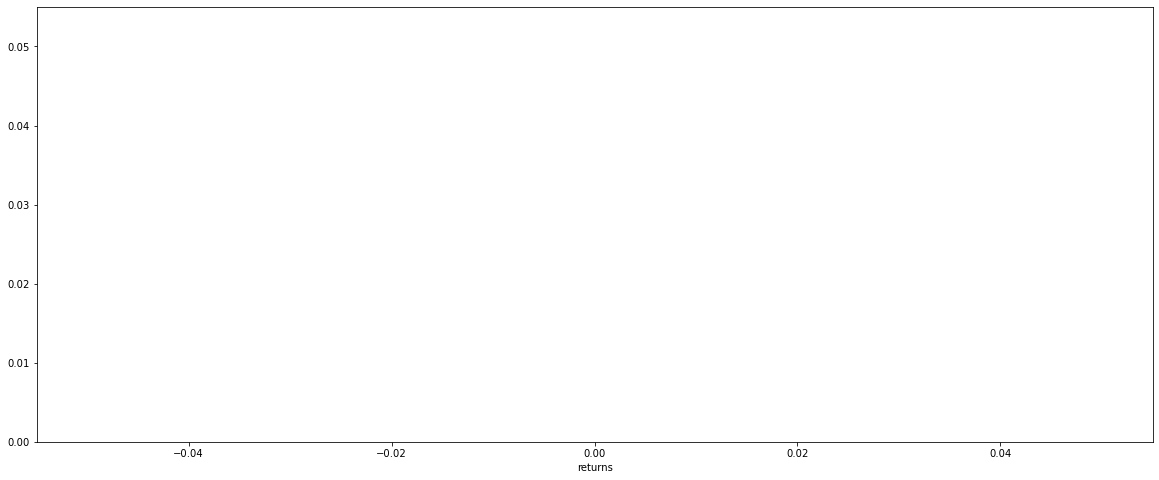

In [38]:
plt.figure (figsize=(20,8))
sns.distplot(np.log(data['returns']), hist=False);
mu = np.mean(np.log(data['returns']))
# sigma = np.std(np.log(data['returns']))
# x = np.linspace(mu - 10*sigma, mu + 10*sigma, 100)
# plt.plot(x, stats.norm.pdf(x, mu, sigma))
# plt.show()

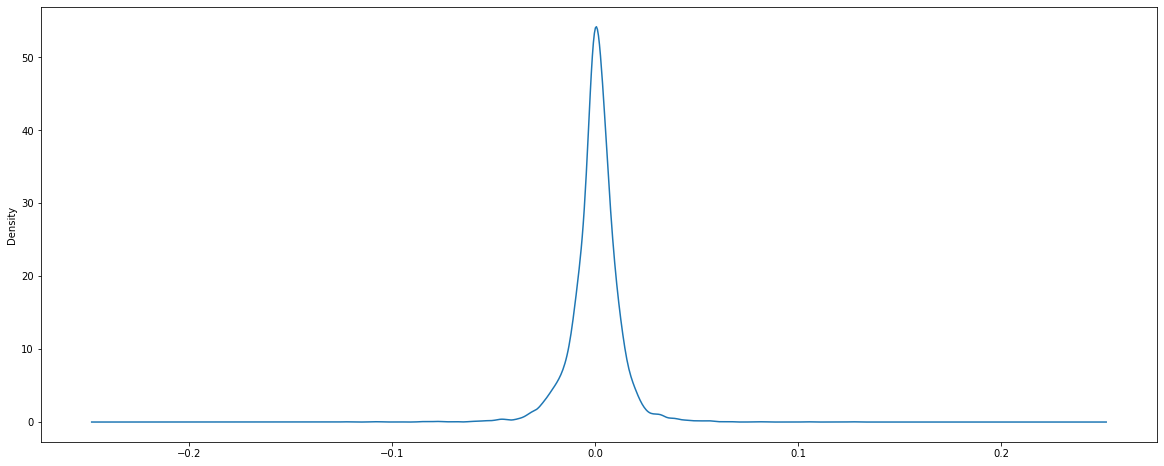

In [42]:
plt.figure (figsize=(20,8))
# data['returns'].plot.kde(ind=np.arange(-3,4,1))
data['returns'].plot.kde()

In [60]:
rolling_window_size = 500
dataset = Returns(data[['returns']], rolling_window_size)
kurtosis_real_dataset = np.array([])
kurtosis_synthetic_dataset = np.array([])
for i in range(0, 24):
    sample = trainer.sample_latent(rolling_window_size)
    kurtosis_synthetic_dataset = np.append(kurtosis_synthetic_dataset, kurtosis(sample))
    kurtosis_real_dataset = np.append(kurtosis_real_dataset, kurtosis(dataset.__getitem__(i)))

#     print(kurtosis(dataset.__getitem__(i)))
kurtosis_real_dataset

array([ 2.32191131,  1.63241664,  2.2656692 ,  6.67281363,  5.41995248,
        3.69330789,  1.24579783,  1.28599211,  0.80961408,  1.10672149,
        0.87682388, -0.05119653,  0.5403782 ,  2.69219669,  9.35144198,
        5.73383291,  2.37281791,  3.25610247,  4.58591562,  1.16256715,
        1.35967678,  2.97403253,  2.23528803,  3.43821976])

In [61]:
simulated_data = pd.DataFrame()
simulated_data['real kurtosis'] = kurtosis_real_dataset
simulated_data['synthetic kurtosis'] = kurtosis_synthetic_dataset
simulated_data

,real kurtosis,synthetic kurtosis
0,2.321911,-0.084936
1,1.632417,-0.171760
2,2.265669,-0.092879
3,6.672814,0.128030
4,5.419952,-0.386094
5,3.693308,-0.262957
6,1.245798,0.414580
7,1.285992,0.413160
8,0.809614,0.277471
9,1.106721,-0.211057


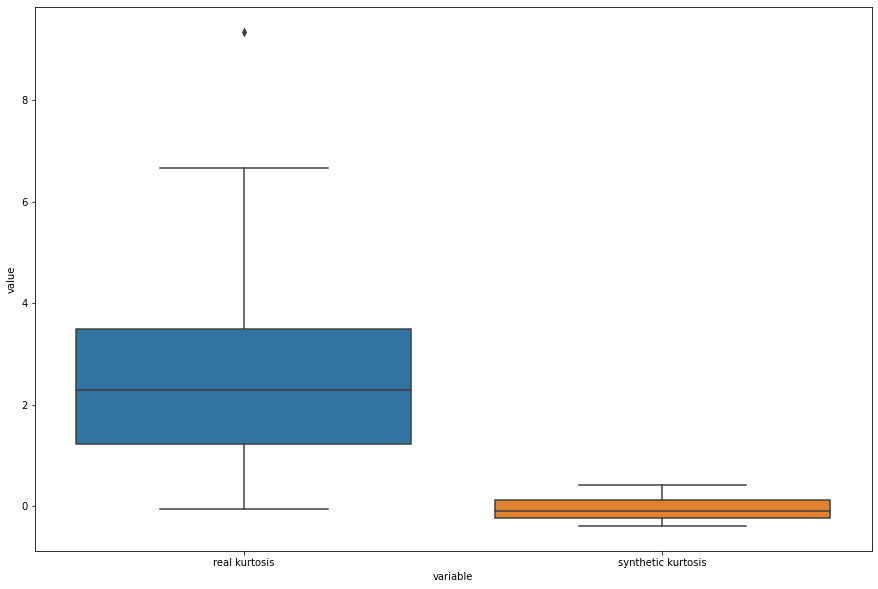

In [62]:
plt.figure (figsize=(15,10))
sns.boxplot(x="variable", y="value", data=pd.melt(simulated_data))

In [43]:
dataset = Returns(data[['returns']], 500)
kurtosis_real_dataset = np
for i in range(0, 30):
    print(kurtosis(dataset.__getitem__(i)))

2.3219113073845614
1.6324166353385392
2.265669199374699
6.672813633863134
5.419952484870159
3.693307894334013
1.2457978323448522
1.2859921133322496
0.809614078726475
1.106721492454886
0.8768238751281783
-0.051196529996305085
0.5403782007844642
2.6921966906426835
9.351441984331872
5.733832914657983
2.3728179127431375
3.256102471702005
4.5859156189377
1.1625671456638873
1.3596767818182949
2.9740325309430204
2.2352880311510974
3.438219756145597
6.436680276961633


IndexError: index 25 is out of bounds for axis 0 with size 25

In [26]:
kurtosis(sample)

0.2599315330922569